<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/drive_checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
#from tensorflow.keras.preprocessing import image
import numpy as np
import scipy
from scipy.io import loadmat
import glob
import h5py
import time
import joblib
from joblib import Parallel, delayed
import sys
import scipy.spatial
import math
import tensorflow as tf
from tensorflow.keras.preprocessing import image

print("Start")

Start


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!ls "/content/drive/MyDrive/GCC_GT"

CreateFrom_Colab  GT  pngs


In [11]:
import os

path = "/content/drive/MyDrive/GCC_GT/CreateFrom_Colab"
os.mkdir(path)

FileExistsError: ignored

In [2]:
!touch "/content/drive/MyDrive/GCC_GT/CreateFrom_Colab/test.txt"

touch: cannot touch '/content/drive/MyDrive/GCC_GT/CreateFrom_Colab/test.txt': No such file or directory


In [12]:
path_list_file = "/content/drive/MyDrive/GCC/all_list.txt"

In [13]:
def get_image_path(file_path):
    file_path_list = file_path.split(" ")
    scene = file_path_list[3][4:]
    image_number = file_path_list[4]
    image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
    return image_path

In [14]:
file = open(path_list_file, 'r')

file_list = file.readlines()

image_path_list = []

for line in file_list:
    image_path_list.append(get_image_path(line))

In [15]:
len(image_path_list)

15212

In [16]:
image_path_list[0]

'/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536371984.png'

In [17]:
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

In [18]:
part_0_list = get_image_pathlist(image_path_list, "Part 0")

In [19]:
len(part_0_list)

1793

In [22]:
(part_0_list[:100])

['/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536371984.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536372385.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536373018.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536375643.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536376505.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536376907.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536378742.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536380840.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536382546.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536385700.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536386507.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536386782.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536387597.png',
 '/content/drive/MyDrive/GCC/Part 0/scene_00_0/pngs/1536387950.png',
 '/content/drive/MyDrive/GCC/Part 

In [24]:
def gaussian_filter_density(gt):
    #print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    pts_copy = pts.copy()
    tree = scipy.spatial.KDTree(pts_copy, leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
    print(gt_count)
    #print(distances)
    #print(locations)
    print('generate density...')
    count = 0
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.
        #print(gt_count)
        if gt_count > 1 and math.isinf(distances[i][1])==False and math.isinf(distances[i][2])==False and math.isinf(distances[i][3])==False:
            #print(distances)
            sigma = (distances[i][1] + distances[i][2]+distances[i][3]) * 0.1
            count+=1
            
        elif gt_count > 1 and math.isinf(distances[i][1])==False and math.isinf(distances[i][2])==False and math.isinf(distances[i][3])==True :
            #print(distances)
            sigma = (distances[i][1] + distances[i][2]) * 0.1
            count+=1

            #print(sigma) 
        elif gt_count > 1 and math.isinf(distances[i][1])==False and math.isinf(distances[i][2])==True and math.isinf(distances[i][3])==False:
            
            sigma = (distances[i][1] + distances[i][3]) * 0.1
            count+=1

        elif gt_count > 1 and math.isinf(distances[i][1])==False and math.isinf(distances[i][2])==True and math.isinf(distances[i][3])==True:
            
            sigma = (distances[i][1]) * 0.1
            count+=1

        else:
            sigma = np.average(np.array(gt.shape)) / 2. / 2.  # case: 1 point
            count+=1

        #print(sigma)
        density += scipy.ndimage.filters.gaussian_filter(pt2d, round(sigma), mode='constant')
    print('done.')
    #print(count)
    #print(np.sum(density))
    return density

In [29]:
def generate_density_map(img_path):
    #print(img_path)
    #print('mat_path ', mat_path)
    mat_path = img_path.replace("pngs","mats").replace(".png",".mat")
    mat = scipy.io.loadmat(mat_path)
    #print(mat)
    imgfile = image.load_img(img_path)
    img = image.img_to_array(imgfile)
    k = np.zeros((img.shape[0], img.shape[1]))
    img_info = mat["image_info"]
    weather_info = mat["weather_info"]
    time_info = mat["time_info"]
    roi_info = mat["roi_info"]
    camera_info = mat["camera_info"]
    gt = img_info[0][0][0]
    for i in range(0, len(gt)):
        #print(gt[i][0])
        #print(gt[i])
        if int(gt[i][0]) < img.shape[0] and int(gt[i][1]) < img.shape[1]:
            #print(gt[i][1],gt[i][0])
            k[int(gt[i][0]), int(gt[i][1])] = 1
    k = gaussian_filter_density(k)
    #print(k)
    output_path = img_path.replace("pngs", "GT").replace('.png', '.h5')
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    print(output_dir)
    print("output", output_path)
    sys.stdout.flush()
    with h5py.File(output_path, 'w') as hf:
        hf['density'] = k
        hf.close()
    return img_path
    #return img_info

#mat_path = "D:/Aca sem 6/FYP/DataSets/GCC/Part 6/scene_60_0/mats/1532367537.mat"
#img_path = "/content/drive/MyDrive/scene_09_2/pngs/1531113494.png"
for img_path in part_0_list[47:53]:
  generate_density_map(img_path)

3535
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_0/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_0/GT/1537259780.h5
3258
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_0/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_0/GT/1537260220.h5
2304
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_0/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_0/GT/1537260577.h5
2369
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_1/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_1/GT/1536407020.h5
1670
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_1/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_1/GT/1536409531.h5
2142
generate density...
done.
/content/drive/MyDrive/GCC/Part 0/scene_00_1/GT
output /content/drive/MyDrive/GCC/Part 0/scene_00_1/GT/1536410395.h5


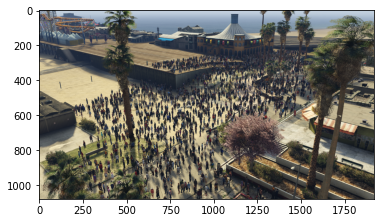

In [30]:
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

3532.3494


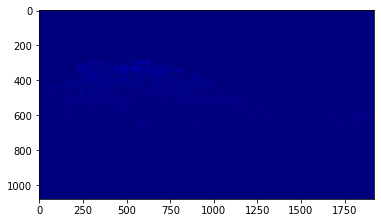

In [32]:
import numpy as np # linear algebra
from matplotlib import cm as CM
from matplotlib import pyplot as plt

import h5py
density_map_path = "/content/drive/MyDrive/GCC/Part 0/scene_00_0/GT/1537259780.h5"
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

print(np.sum(groundtruth))